In [19]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
import scipy

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
from typing import Optional

import pandas as pd
from IPython.display import Image
from scipy.stats import boxcox
from statsforecast.arima import ndiffs, nsdiffs
from statsforecast.models import AutoETS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from utilsforecast.losses import mae, rmse, smape

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image, Markdown, display
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import fourier, pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import SplineTransformer
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

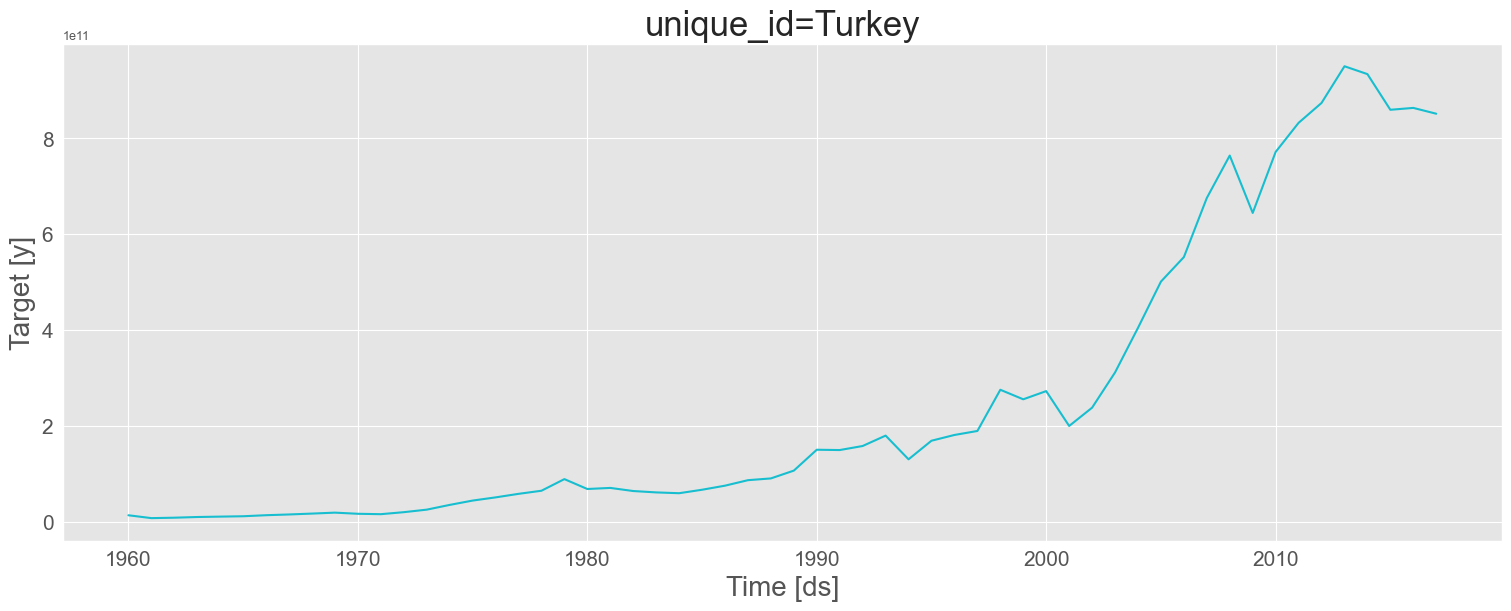

In [17]:
df = pd.read_csv("../DATA/global_economy.csv")
df.ds = pd.to_datetime(df.ds, format="%Y")
df = df[df.unique_id == "Turkey"]
gdp = df[["unique_id", "ds"]]
gdp["y"] = df["GDP"]
gdp = gdp.reset_index(drop=True)
plot_series(gdp)

## Stationarity testing

In [29]:
kpss_stat, kpss_pvalue, _, _ = kpss(gdp.y)

print(f"kpss_stat: {kpss_stat:.3f}, kpss_pvalue: {kpss_pvalue:.2f}")

kpss_stat: 1.002, kpss_pvalue: 0.01


## Box Cox Transform

kpss_stat: 1.229, kpss_pvalue: 0.01


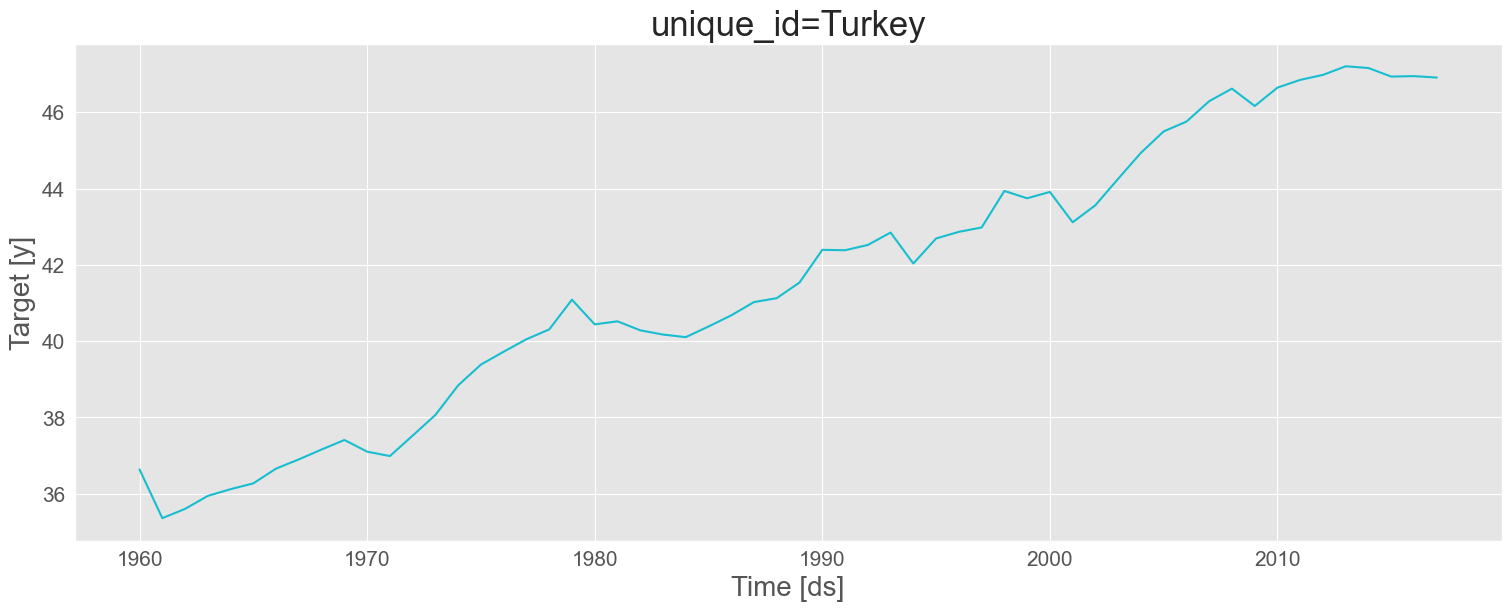

In [30]:
gdp_cox = gdp.copy()
gdp_cox["y"], lbd = boxcox(gdp_cox.y)

kpss_stat, kpss_pvalue, _, _ = kpss(gdp_cox.y)

print(f"kpss_stat: {kpss_stat:.3f}, kpss_pvalue: {kpss_pvalue:.2f}")
plot_series(gdp_cox)

# Derivation

kpss_stat: 0.065, kpss_pvalue: 0.10


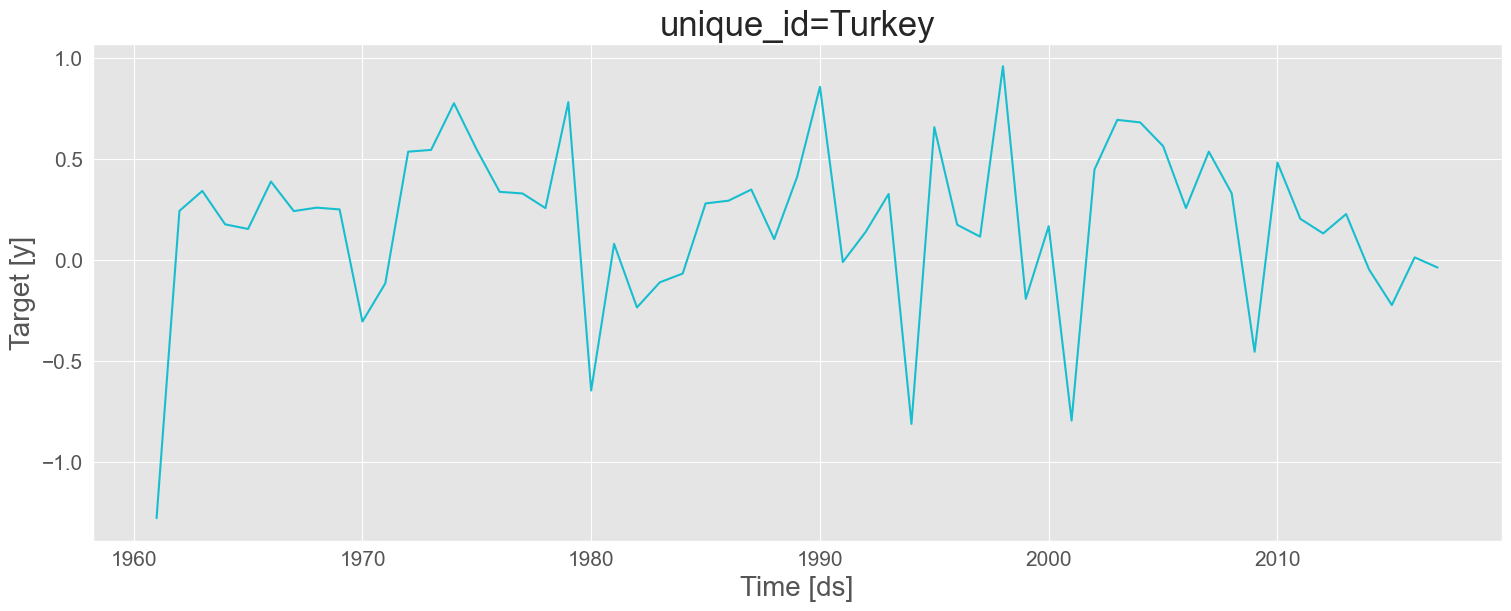

In [89]:
kpss_stat, kpss_pvalue, _, _ = kpss(gdp_cox.y.diff().dropna())
print(f"kpss_stat: {kpss_stat:.3f}, kpss_pvalue: {kpss_pvalue:.2f}")

gdp_cox_deriv = gdp_cox.copy()
gdp_cox_deriv.y = gdp_cox_deriv.y.diff()
plot_series(gdp_cox_deriv)

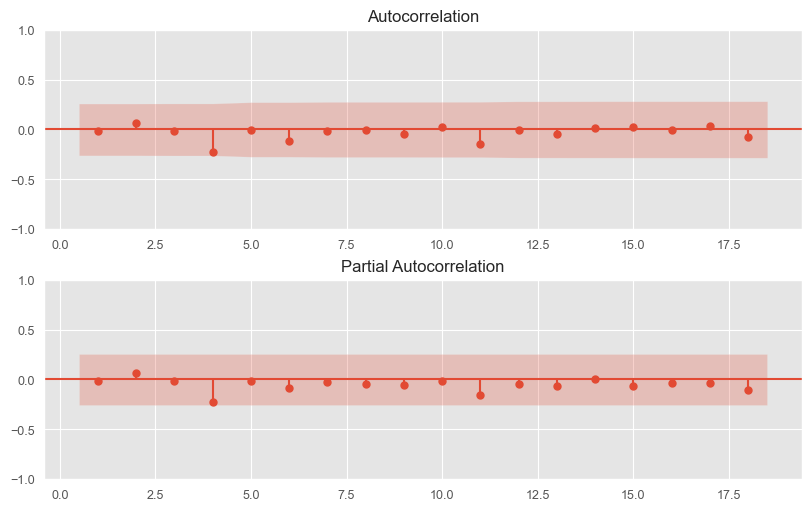

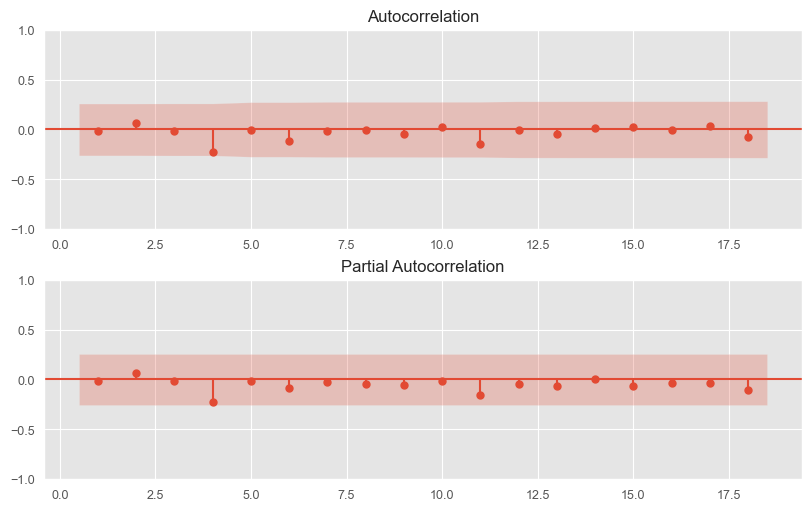

In [55]:
fig, axes = plt.subplots(2, 1)
plot_acf(gdp_cox_deriv.y.dropna(), ax=axes[0], zero=False)
plot_pacf(gdp_cox_deriv.y.dropna(), ax=axes[1], zero=False)

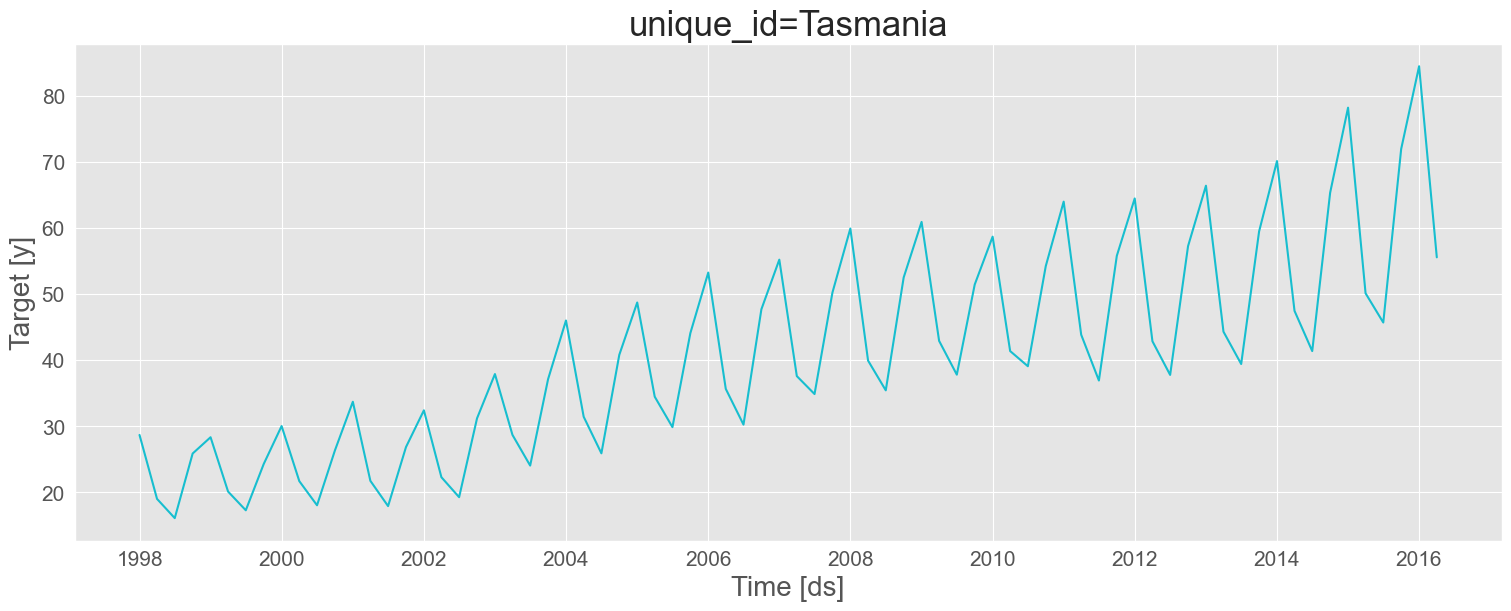

In [73]:
df = pd.read_csv("../DATA/aus_accomodation.csv")
df.ds = pd.to_datetime(df.ds)
df = df[df.unique_id == "Tasmania"]
taking = df[["ds", "unique_id"]]
taking["y"] = df.Takings
taking = taking.reset_index(drop=True)
plot_series(taking)

In [78]:
taking.head()

,ds,unique_id,y
0,1998-01-01,Tasmania,28.699
1,1998-04-01,Tasmania,19.018
2,1998-07-01,Tasmania,16.106
3,1998-10-01,Tasmania,25.886
4,1999-01-01,Tasmania,28.351


## Box Cox Transform

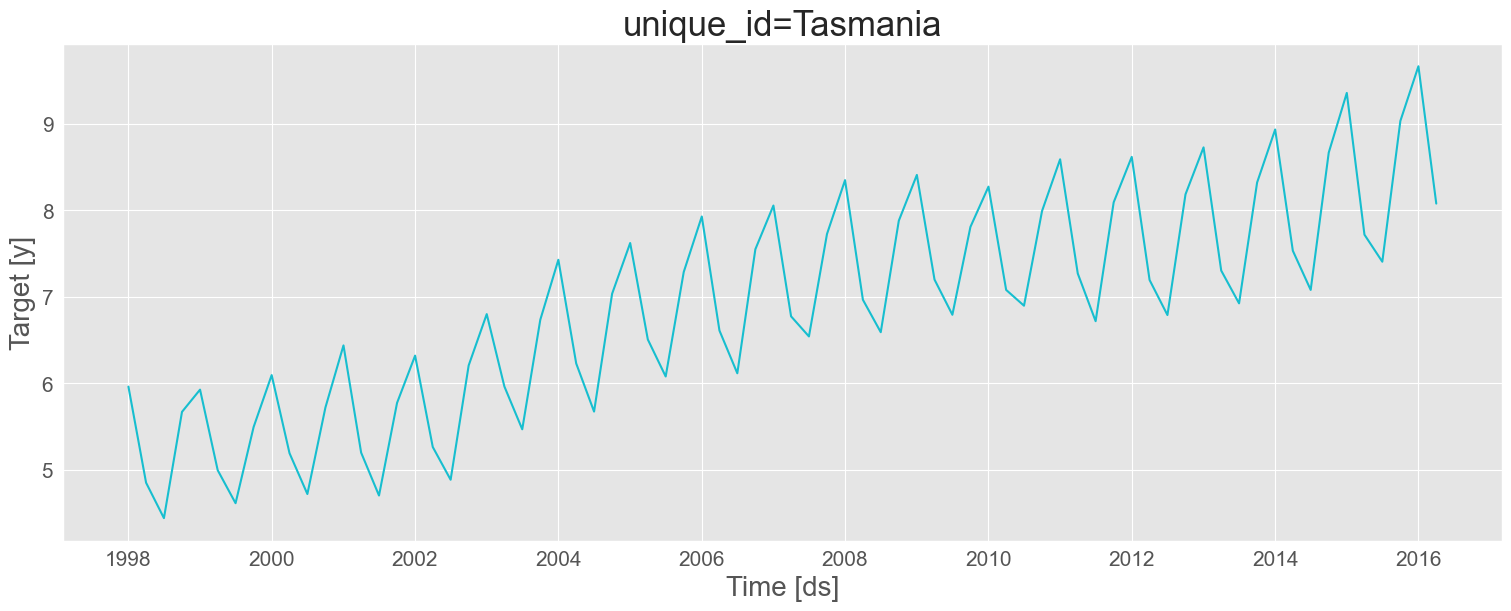

In [77]:
box_cox_y, lbd = boxcox(taking.y)
box_cox_taking = taking.copy()
box_cox_taking.y = box_cox_y
plot_series(box_cox_taking)

In [87]:
kpss_stat, kpss_pvalue, _, _ = kpss(box_cox_taking.y)
print(f"kpss_stat: {kpss_stat:.3f}, kpss_pvalue: {kpss_pvalue:.2f}")

kpss_stat: 1.489, kpss_pvalue: 0.01


## Seasonality Differenciation

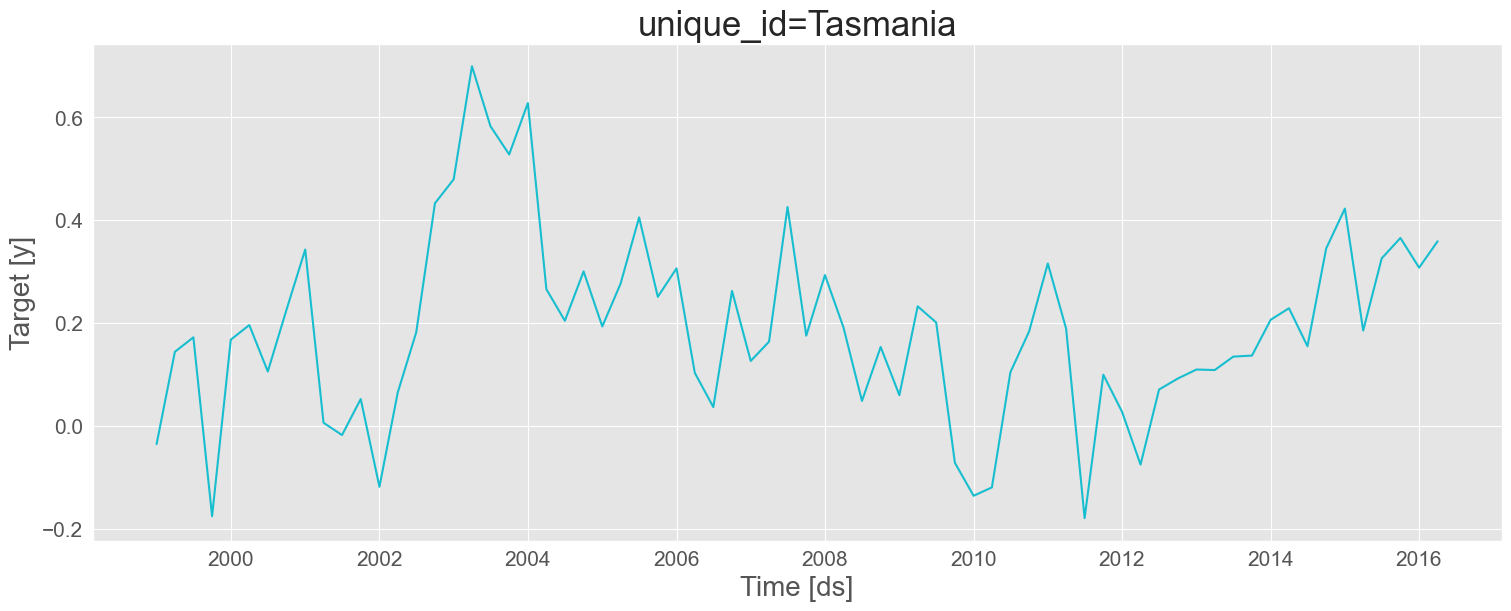

In [85]:
# Quaterly seasonality

taking_season_diff = box_cox_taking.copy()
taking_season_diff.y = box_cox_taking.y.diff(periods=4)
taking_season_diff = taking_season_diff.dropna()
plot_series(taking_season_diff)

In [86]:
kpss_stat, kpss_pvalue, _, _ = kpss(taking_season_diff.y)
print(f"kpss_stat: {kpss_stat:.3f}, kpss_pvalue: {kpss_pvalue:.2f}")

kpss_stat: 0.131, kpss_pvalue: 0.10
